# KeyLLM - Keyword Extraction with Mistral 7B
* Notebook by Adam Lang
* Date: 9/26/2024

# Overview
* This notebook is from a tutorial that Maarten Grootendorst did introducing his new package KeyLLM. All credit goes to him for his amazing work on this package as well as BERTopic.
* I am going to code along with Maarten but also add some other things as I go to use his methods as a starting point for future experiments and modeling.
* Link to his original post: https://www.maartengrootendorst.com/blog/keyllm/

## Install packages
* What we see below is:
1. SentenceTransformers -- install from git repo.
2. keybert
3. huggingface transformers --> we need upgraded version to run quantized LLMs like Mistral in this notebook.

In [1]:
%%capture
!pip install --upgrade git+https://github.com/UKPLab/sentence-transformers
!pip install keybert ctransformers[cuda]
!pip install --upgrade git+https://github.com/huggingface/transformers

## Load Mistral Model
* We will use the quantized version of Mistral from `TheBloke` repo on huggingface.
* There are different versions of quantized Mistral, this is the one that Maarten uses in his tutorial: https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF
* Maarten has an awesome blog post on the various quantization methods here: https://newsletter.maartengrootendorst.com/p/which-quantization-method-is-right
* To summarize some of what he says:
1. GGUF which he uses in this notebook stands for "GPT-Generated Unified Format". The purpose is to allow users to use the CPU to run a large language model but offload some layers to GPU for speeding up usage.
2. Another method that Maarten mentions in his post and there is a Bloke model for is "AWQ" or "Activation-aware Weight Quantization.
  * AWQ assumes that not all weights are equally important for an LLM to perform well and thus a portion of the model weights are skipped over during quantization.

* The overall point of quantization here is to compress the model.
* Huggingface gives us `ctransformers` which allows us to utilize the quantized LLMs.

In [2]:
## load mistral quantized model from HF
from ctransformers import AutoModelForCausalLM

## gpu_layers set to num of layers to offload to GPU -- the more the better.
## set to 0 if no GPU acceleration is needed or available
model = AutoModelForCausalLM.from_pretrained(
    'TheBloke/Mistral-7B-Instruct-v0.2-GGUF',
    model_file='mistral-7b-instruct-v0.2.Q4_K_M.gguf',
    model_type='mistral',
    gpu_layers=50,
    hf=True,

)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.2.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

CTransformersModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


## Load Mistral Tokenizer

In [3]:
from transformers import AutoTokenizer, pipeline


## Mistral tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [4]:
## setup huggingface pipeline
generator = pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50, #set this to 50 for keyword extraction, don't want it to be too large
    repetition_penalty=1.1
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Prompt Engineering Experiments with Mistral-7B
* We will start with some basic prompt examples to get a feel for mistral 7b

In [5]:
## basic prompts
response = generator("What is 2+2?")
print(response[0]['generated_text'])

What is 2+2?

This question may seem simple, but it's actually a fundamental one in mathematics. The answer is 4. But why is that?

To understand this, we need to go back to the basics of arithmetic


## Keyword Extraction Example - prompting with Mistral-7B

In [6]:
## keyword extraction prompt
prompt = """
I have the following document:
* I apologize, but I don't have access to specific information about your department's skill profile. Skill profiles can vary significantly between different departments and organizations.


Extract 5 keywords from that document.
"""

## response
response = generator(prompt)
print(response[0]["generated_text"])


I have the following document:
* I apologize, but I don't have access to specific information about your department's skill profile. Skill profiles can vary significantly between different departments and organizations. 


Extract 5 keywords from that document.
1. Department's skill profile
2. Skill profiles
3. Variably
4. Significantly
5. Departments and organizations.


## Prompt Templates
* This is also from Marteen's blog post. This demonstrates the Mistral 7B prompt template.
* These prompt templates vary for each LLM.
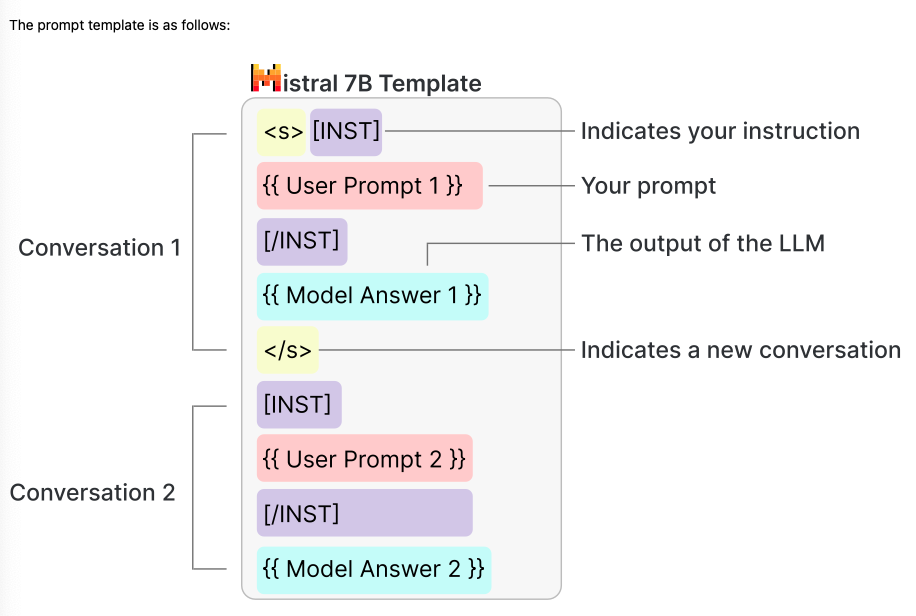

## Keyword Extraction Prompt Templates
* This again is from Marteen's blog post, but demonstrates how you can take advantage of the power of an LLM like Mistral to perform Keyword Extraction using the given prompt template.
* Here is what Marteen says you need:

1. **Example Prompt** - shows LLM what "good" output looks like. Source: Marteen's blog post.
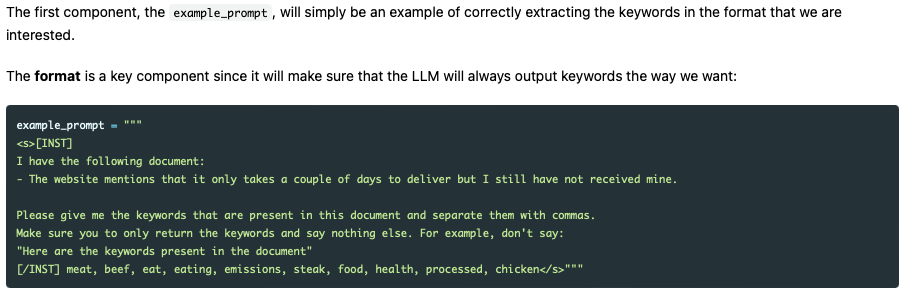



Example Prompt

In [10]:
## this is what it looks like completed

example_prompt = """
<s>[INST]
I have the following document:
- The entire website mentions that it only takes a copule of days to deliver but I still have not received mine.

Please give me keywords that are present in this document and separate them with commas.
Make sure to only return keywords and say nothing else. For example, don't say:
"Here are the keywords present in the document"
[/INST] meat, beef, eat, eating, emissions, steak, food, health, processed, chicken</s>"""

2. Keyword prompt - asks the LLM to extract the keywords from the text. Source: Marteen's blog post:
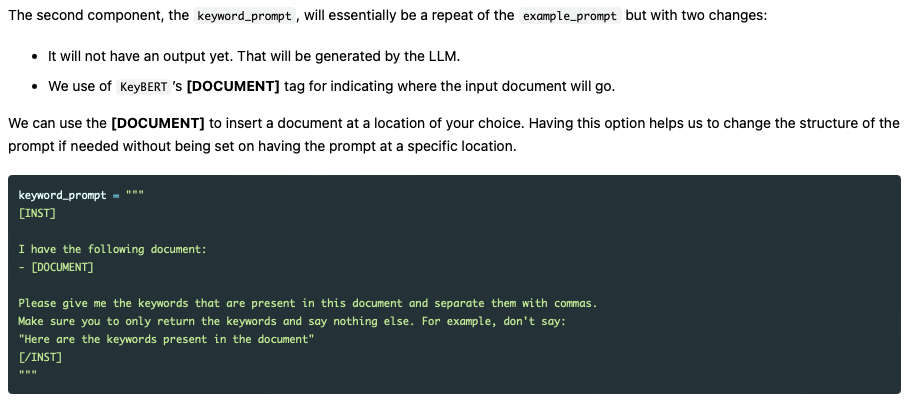


Keyword Prompt
* Note: `[DOCUMENT]` is the actual document you want to exract keywords from with the LLM.

In [11]:
## keyword prompt
keyword_prompt = """
[INST]

I have the following document:
- [DOCUMENT]

Please give me keywords that are present in this document and separate them with commas.
Make sure to only return keywords and say nothing else. For example, don't say:
"Here are the keywords present in the document"
[/INST]
"""

Now we can combine the **Example Prompt** with the **Keyword Prompt**

In [12]:
## combine example + keyword prompts
prompt = example_prompt + keyword_prompt

## print the prompt first
print(prompt)


<s>[INST]
I have the following document:
- The entire website mentions that it only takes a copule of days to deliver but I still have not received mine.

Please give me keywords that are present in this document and separate them with commas.
Make sure to only return keywords and say nothing else. For example, don't say:
"Here are the keywords present in the document"
[/INST] meat, beef, eat, eating, emissions, steak, food, health, processed, chicken</s>
[INST]

I have the following document:
- [DOCUMENT]

Please give me keywords that are present in this document and separate them with commas.
Make sure to only return keywords and say nothing else. For example, don't say:
"Here are the keywords present in the document"
[/INST]



Summary:
* Ok so those are simple examples of the workflow that Marteen recommends using KeyLLM.
* Now we will get into how Marteen recommends using KeyLLM with KeyBERT and the various use cases.

# Keyword Extraction with **KeyLLM**
* This is an example from Marteen's blog post of the most simple/basic way to use KeyLLM to extract keywords from a document.
* Here is the diagram that Marteen recommends following:
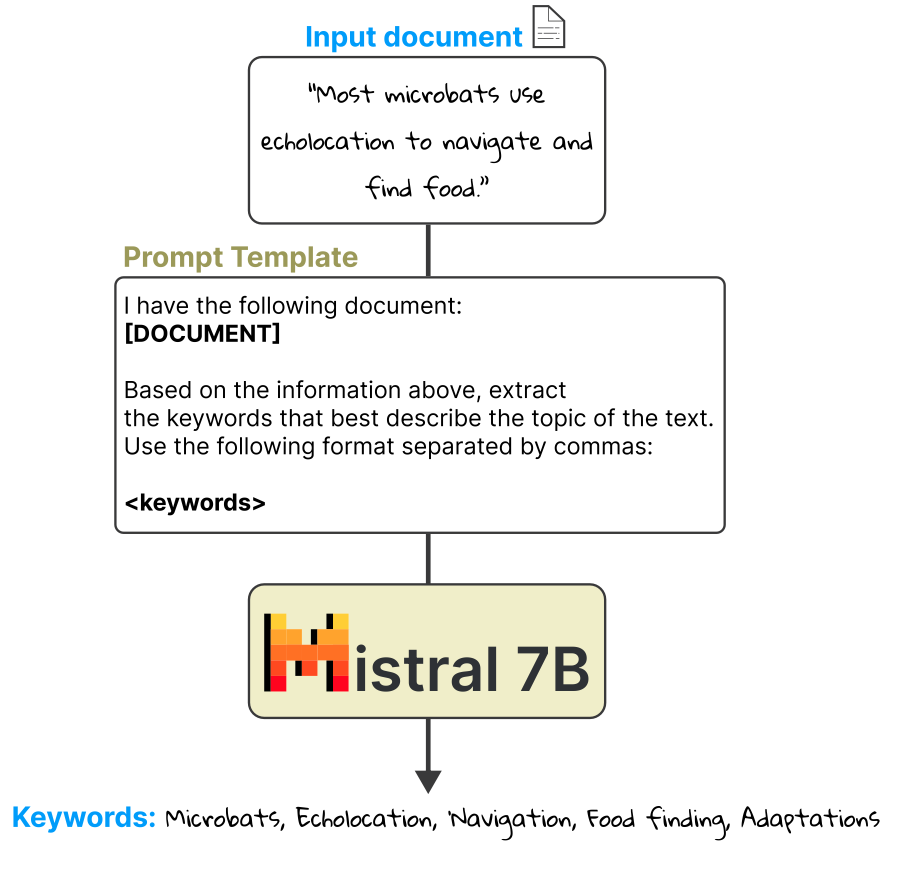

Notes about the workflow above:
1. Input document to LLM
2. Prompt Template - example + keyword prompt
3. LLM of choice (Mistral 7B or other)
4. Extract keywords

Note: To use other LLMs see the KeyBERT documentation here: https://maartengr.github.io/KeyBERT/guides/llms.html

In [13]:
## vanilla or simple keyword extraction
from keybert.llm import TextGeneration
from keybert import KeyLLM

## send prompt to LLM - generator is hf mistral 7B pipeline
llm = TextGeneration(generator, prompt=prompt)
## setup keyword model
kw_model = KeyLLM(llm)

After you instantiate the LLM and the keyword model, then all you have to do is extract the keywords.

In [14]:
## get some documents
documents = [
"The website mentions that it only takes a couple of days to deliver but I still have not received mine.",
"I received my package!",
"Whereas the most powerful LLMs have generally been accessible only through limited APIs (if at all), Meta released LLaMA's model weights to the research community under a noncommercial license."
]

## extract keywords
keywords = kw_model.extract_keywords(documents); keywords

[['website',
  'mention',
  'couple',
  'days',
  'deliver',
  'still',
  'received',
  'mine.'],
 ['package', 'received'],
 ['LLMs',
  'most powerful',
  'accessible',
  'limited APIs',
  'research community',
  'noncommercial license',
  'model weights',
  'release',
  'Meta.']]

Summary:
* We can see that it extracted only unigrams from the document because that is the prompt that we gave the LLM.
* If we want to extract bigrams, trigrams and phrases we either need to change the prompt or there are keyBERT settings we can change.

# Efficient Keyword Extraction with **KeyLLM**
* If we have thousands of documents the above approach is not ideal nor efficient.
* We can use embedding models with LLM to do this.
* Here is how Marteen recommends doing this:
1. Embed documents and convert to numeric representations.
2. Find which documents are most similar.
  * We assume docs that are highly similar have the same keywords so no need to extract keywords for all documents.
3. Extract keywords from 1 document in each cluster and assign keywords to all documents in same cluster.

* Overall this is very flexible and efficient.
* Clusters we will generate are based on similarity between documents without considering the structure of the clusters.
* Example diagram from Marteen's blog post:
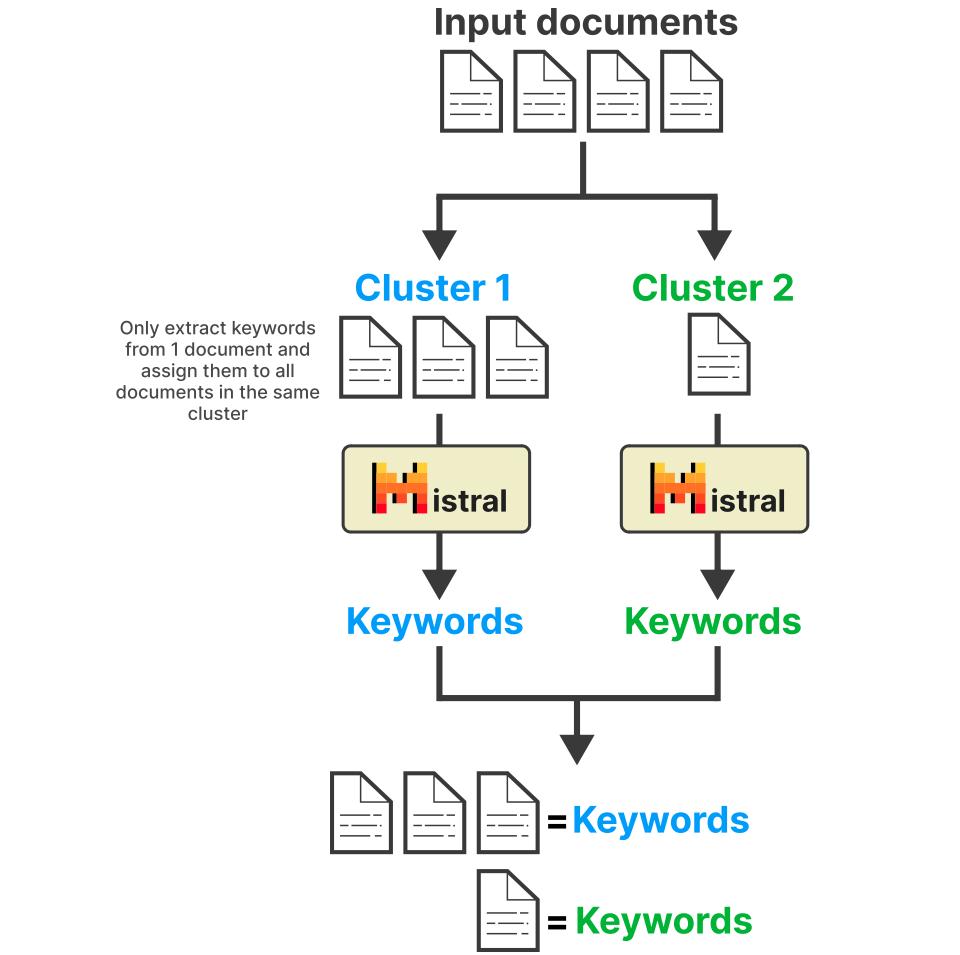


* The goal is to find clusters where documents are highly similar to each other.
  * Extracting from 1 document we can then assign to all documents.

## Process for Efficient keyword extraction
* Embed documents
* Pass to `.extract_keywords`.
* Set threshold for extraction -- want this to be how similar documents will minimally need to be in order to assign to same cluster.
  * If you increase threshold to 0.95, documents will be nearly identical.
  * If you decrease to 0.50, then docuemnts will be about same topic or more diverse.

In [20]:
## 1. embeddings
from keybert import KeyLLM
from sentence_transformers import SentenceTransformer

## 2. instantiate embedding model
model = SentenceTransformer('BAAI/bge-small-en-v1.5')
## 3. create embeddings
embeddings = model.encode(documents, convert_to_tensor=True)

## 4. send to KeyLLM for clustering
kw_model = KeyLLM(llm)

## 5. Extract keywords
keywords = kw_model.extract_keywords(documents, embeddings=embeddings, threshold=0.5)

In [21]:
## let see the keywords
keywords

[['website',
  'mention',
  'couple',
  'days',
  'deliver',
  'still',
  'received',
  'mine.'],
 ['website',
  'mention',
  'couple',
  'days',
  'deliver',
  'still',
  'received',
  'mine.'],
 ['LLMs',
  'most powerful',
  'accessible',
  'limited APIs',
  'research community',
  'noncommercial license',
  'model weights',
  'release',
  'Meta.']]

Summary:
* We can see the first 2 documents have exactly the SAME KEYWORDS because they are very similar.
* The 3rd document is more diverse.

# Efficient Keyword Extraction with KeyBERT and KeyLLM
* In this example Maarten demostrates that before passing the embeddings to **KeyLLM** to do zero-shot keyword extraction, we can extend this by using the power of **KeyBERT**.
* **KeyBERT** generates keywords and embeds documents.
  * So, we can use KeyBERT to simplify the entire pipeline but also use it to suggest keywords to the LLM.
  * The suggested keywords by KeyBERT can help the LLM ultimately decide which keywords to use and extract and search for.
  * This actually is a pretty neat way to "ground" the LLM or "seed" it with knowledge as you would with RAG.
  * Here is the example from Maarten's blog:
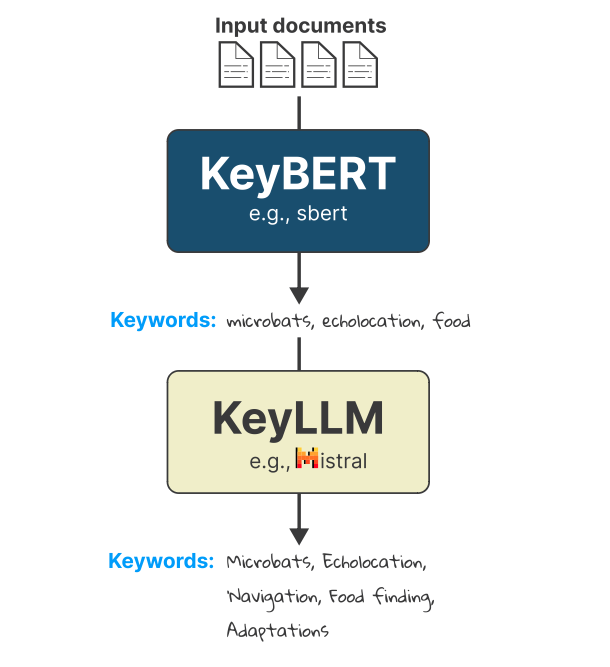

In [17]:
## keyBERT --> KeyLLM
from keybert import KeyLLM, KeyBERT

# 1. use KeyBERT to Load keywords into KeyLLM
kw_model = KeyBERT(llm=llm, model='BAAI/bge-small-en-v1.5')

# 2. extract keywords
keywords = kw_model.extract_keywords(documents, threshold=0.5)

In [18]:
## keywords output
keywords

[['website',
  'mention',
  'couple',
  'days',
  'deliver',
  'still',
  'received',
  'mine.'],
 ['website',
  'mention',
  'couple',
  'days',
  'deliver',
  'still',
  'received',
  'mine.'],
 ['LLMs',
  'most powerful',
  'accessible',
  'limited APIs',
  'research community',
  'noncommercial license',
  'model weights',
  'release',
  'Meta.']]